# 24-2 머신러닝 기말 프로젝트

## 신용카드 사기 거래 탐지 모델 개발

머신러닝을 사용하여 신용카드 사기 거래를 탐지하는 모델을 개발하는 것을 목표로 합니다.  
신용카드 사기 거래를 자동으로 탐지하여 고객과 금융 시스템을 보호하는데 사용할 수 있는 신뢰성 높은 모델을 구축하는 것이 최종 목표입니다.  
주요 단계는 다음과 같습니다.

1. 데이터 이해하기  
2. 데이터 전처리  
3. 모델 학습 및 평가  
   - 랜덤 포레스트  
   - XGBoost  
4. 알고리즘 비교   

---

### 요약

#### **사용 데이터**  
- **출처:** [Kaggle 신용카드 사기 탐지 데이터셋](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)  
- **데이터 크기:** 284,807행 × 31열  
- **주요 특징:**  
  - **Time:** 거래 발생 시간 (초 단위)  
  - **V1~V28:** PCA로 변환된 비식별화 특징  
  - **Amount:** 거래 금액  
  - **Class:** 라벨 (0: 정상 거래, 1: 사기 거래)  

---

#### **알고리즘**  

1. **랜덤 포레스트 (Random Forest)**  
   - **Roc-Auc:** 0.8528 (85.28%)  

2. **XGBoost**  
   - **Roc-Auc:** 0.9807 (98.07%)  

-> XGBoost가 더 적합하여 해당 알고리즘으로 선택하였음.


# 1. 데이터 이해하기

## 1.1 패키지 설치 및 임포트

필요한 라이브러리와 패키지를 설치 및 불러와 데이터 분석과 모델링을 위한 환경을 준비합니다.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import gc

# pandas 설정
pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  # RandomForestClassifier에서 사용할 지표
NUM_ESTIMATORS = 100 # RandomForestClassifier에서 사용할 추정기 수
NO_JOBS = 4 # RandomForestClassifier에서 사용할 병렬 작업 수

# 검증 및 테스트 데이터 비율
VALID_SIZE = 0.20  # 검증 데이터 비율
TEST_SIZE = 0.20  # 테스트 데이터 비율

IS_LOCAL = False

## 1.2 데이터 읽기

In [2]:
data_df = pd.read_csv("creditcard.csv")

## 1.3 데이터 확인하기

In [3]:
print("신용카드 사기 탐지 데이터 행:", data_df.shape[0], " 열:", data_df.shape[1])

신용카드 사기 탐지 데이터 행: 284807  열: 31


In [4]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


데이터의 각 칼럼 정보는 다음과 같습니다.

<br>V1~V28 -> 개인정보로 공개되지 않은 값
<br>Time -> 시간
<br>Amount -> 신용카드 거래 금액
<br>Class -> 사기 여부 (1:사기, 0:정상)

<br>데이터는 284807행, 31열로 이루어져 있다.

## 1.4 결측값 확인

In [6]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


결측값이 없는 데이터임을 알 수 있습니다.

## 1.5 데이터 불균형

In [7]:
# 'Class' 컬럼의 값 개수 계산
temp = data_df["Class"].value_counts()

# DataFrame 생성 (각 클래스와 그에 해당하는 값의 개수)
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

# 바 그래프를 위한 trace 정의
trace = go.Bar(
    x = df['Class'],  # x축: 클래스 값
    y = df['values'],  # y축: 각 클래스의 개수
    name="Credit Card Fraud Class - 데이터 불균형 (사기 아님 = 0, 사기 = 1)",  # 그래프 이름
    marker=dict(color="Red"),  # 막대 그래프의 색상 설정
    text=df['values']  # 막대 위에 표시할 값
)

# 데이터와 레이아웃을 설정
data = [trace]
layout = dict(
    title = 'Credit Card Fraud Class - 데이터 불균형 (사기 아님 = 0, 사기 = 1)',  # 제목
    xaxis = dict(title = 'Class', showticklabels=True),  # x축 레이블
    yaxis = dict(title = '거래 수'),  # y축 레이블
    hovermode = 'closest',  # hover 시 가장 가까운 값을 표시
    width=600  # 그래프 너비 설정
)

# 그래프 데이터와 레이아웃을 합쳐서 표시
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')  # 그래프 출력

492 데이터(0.172%)만 사기임을 알 수 있음. 이는 불균형하다는 것을 의미함.

# 2. 데이터 전처리

## 2.1 데이터 탐색

### 2.1.1 시간에 따라

In [8]:
# 'Class'가 0인 데이터에서 'Time' 값만 선택 (사기 아님)
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]

# 'Class'가 1인 데이터에서 'Time' 값만 선택 (사기)
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

# 각 클래스를 포함하는 리스트
hist_data = [class_0, class_1]

# 그룹 라벨 설정 (사기 아님, 사기)
group_labels = ['사기 아님', '사기']

# 밀도 그래프 생성
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)

# 그래프 레이아웃 업데이트 (제목, x축 레이블 설정)
fig['layout'].update(title='신용카드 거래 시간 밀도 그래프', xaxis=dict(title='시간 [초]'))

# 그래프 출력
iplot(fig, filename='dist_only')

사기 거래는 사기가 아닌 거래보다 더 균등하게 분포돼 있다.

In [9]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


거래 데이터를 시간 단위(Hour)와 거래 유형(Class)별로 그룹화한 후, 거래 금액(Amount)의 통계 정보를 집계하여 새로운 데이터프레임으로 정리합니다.

### 2.1.2 시간대별 총 거래 금액 (Sum)

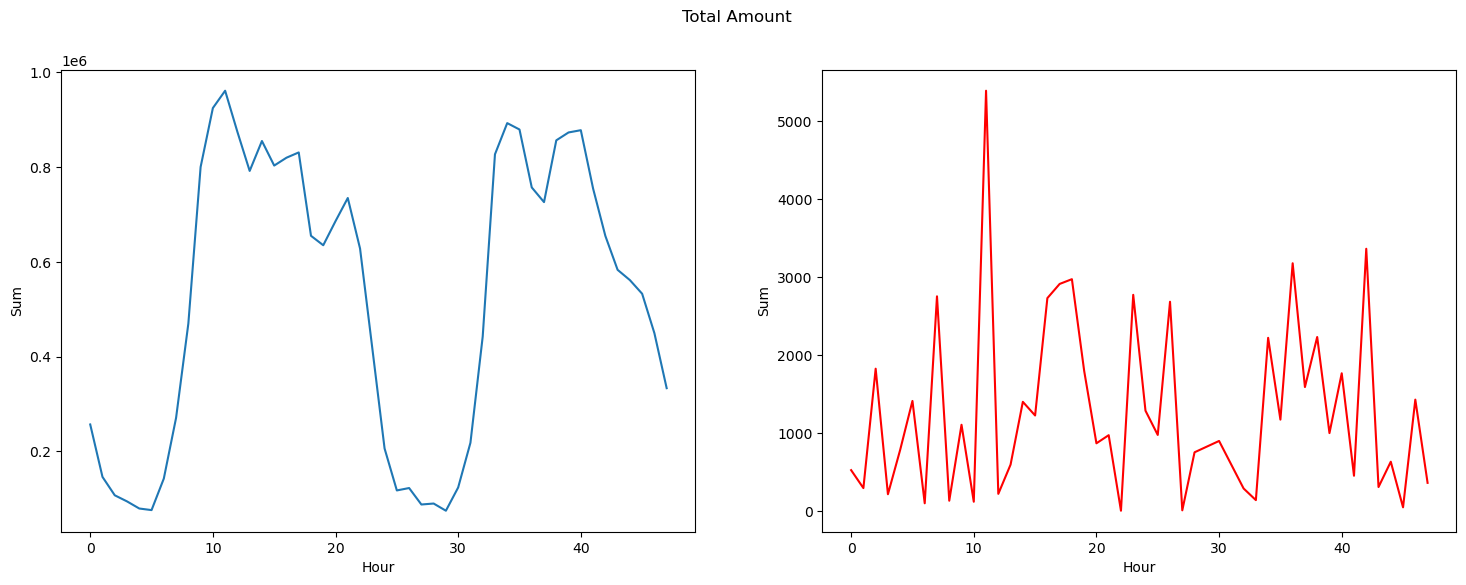

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount") # 총금액
plt.show();

### 2.1.3 시간대별 거래 횟수 (Transactions)

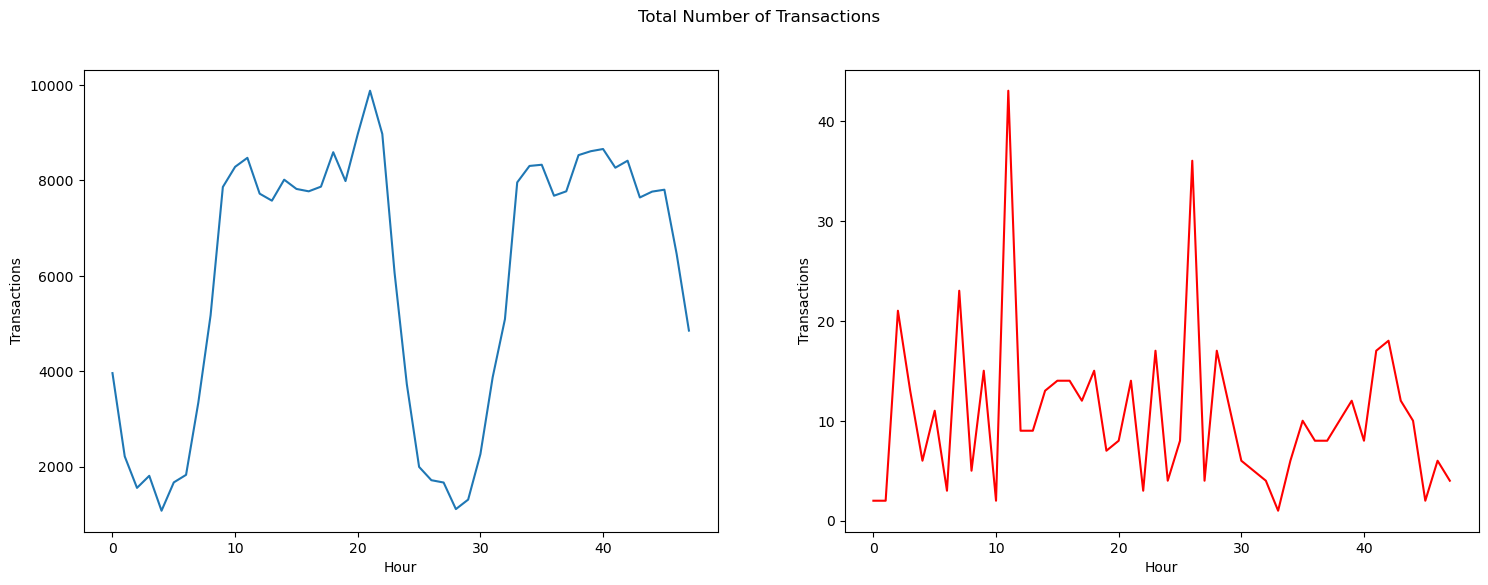

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions") # 총 거래 수
plt.show();

### 2.1.4 시간대별 평균 거래 금액 (Mean)

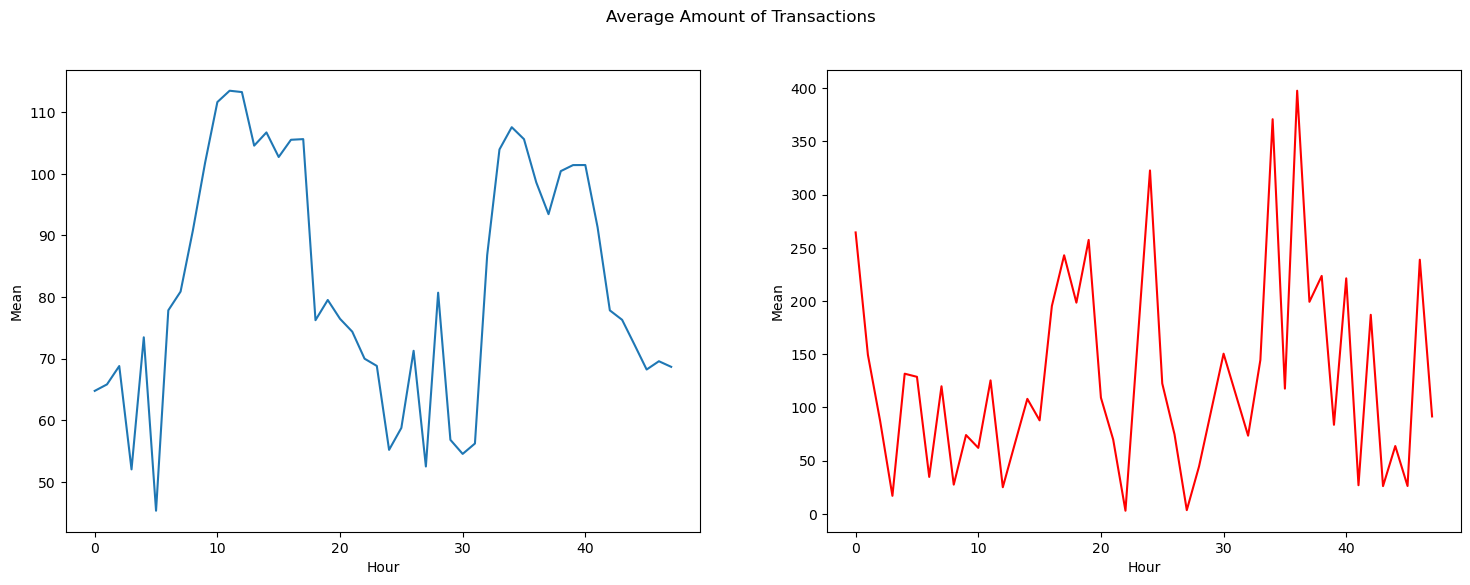

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions") # 평균 거래량
plt.show();

### 2.1.5 시간대별 최대 거래 금액 (Max)

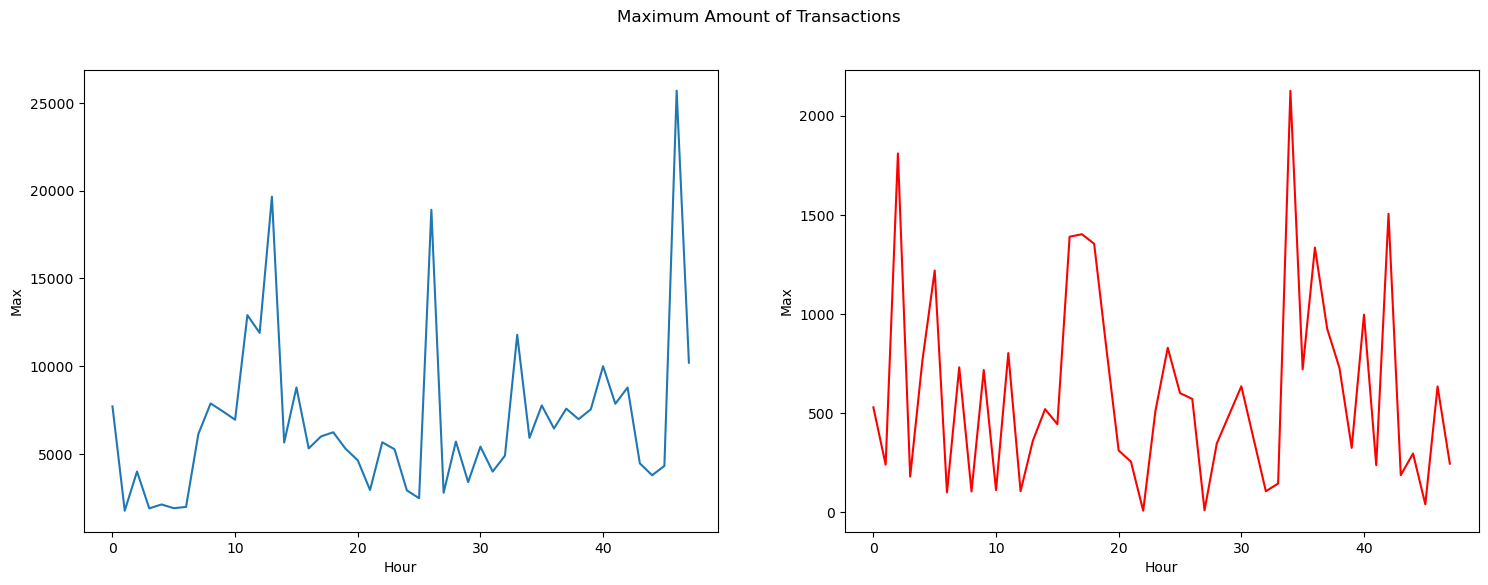

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions") #최대 거래량
plt.show();

### 2.1.6 시간대별 중간 거래량 (Median)

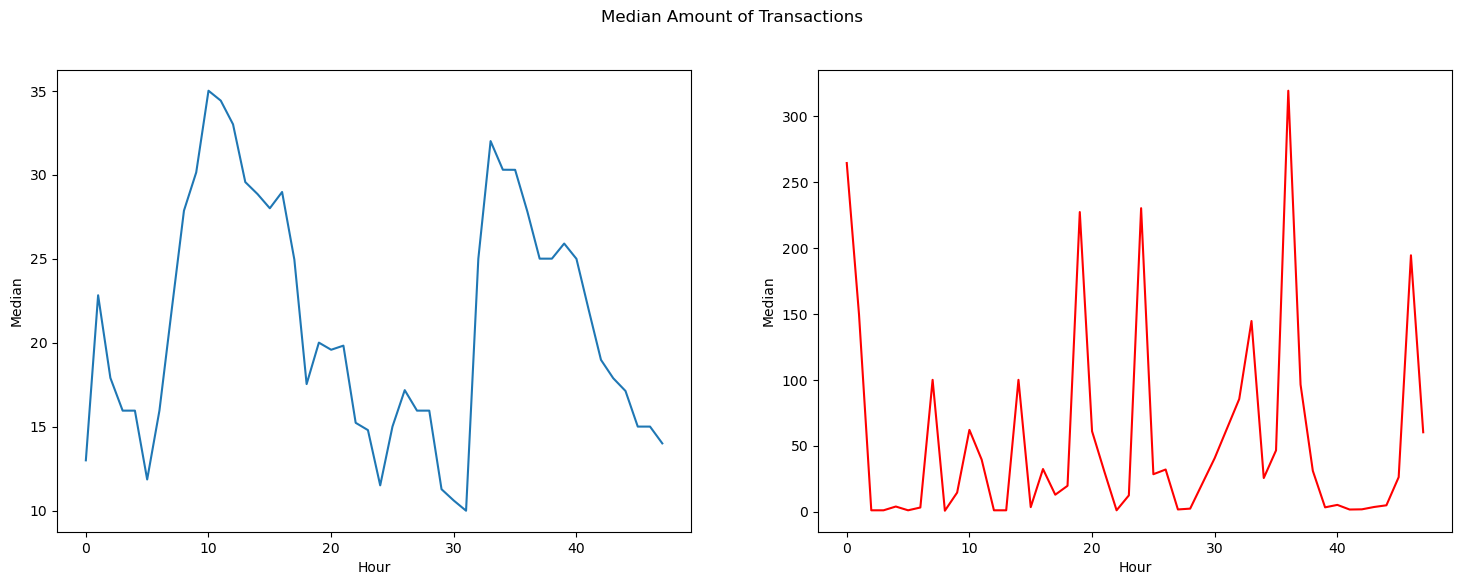

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions") # 중간 거래량
plt.show();

### 2.1.7 시간대별 최소 거래 금액 (Min)

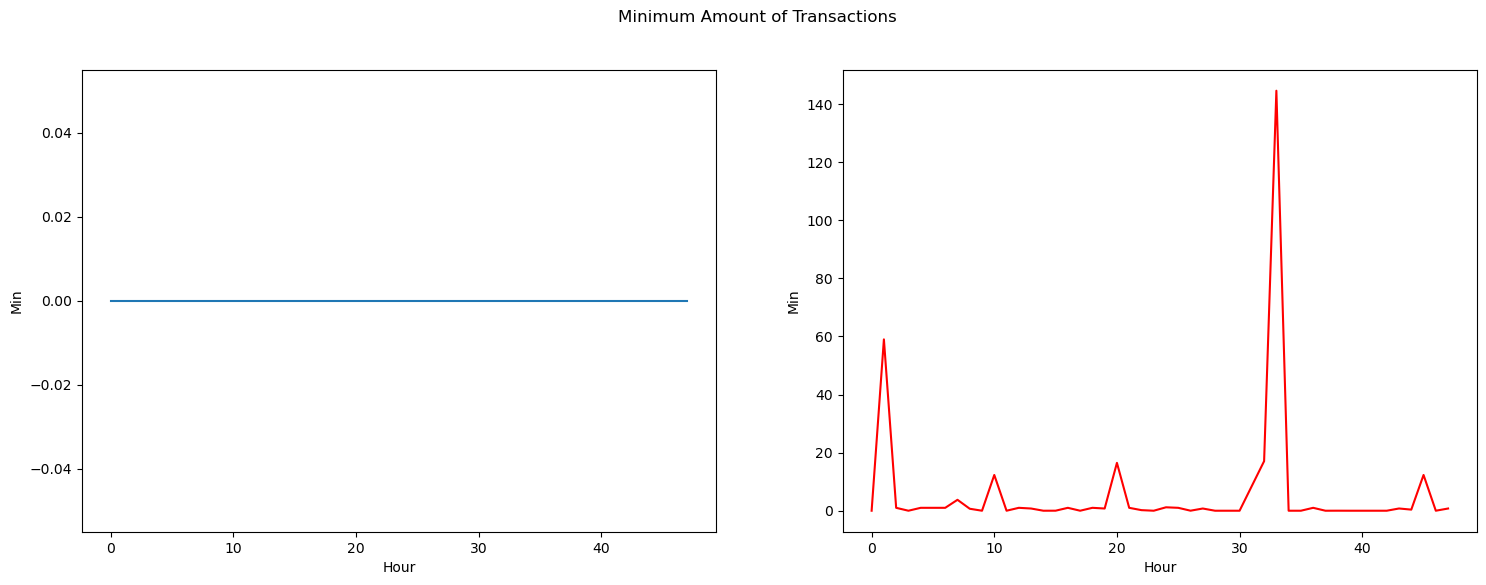

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions") # 최소 거래 금액
plt.show();

### 2.1.8 거래 유형(Class)별 거래 금액(Amount) 분포 확인

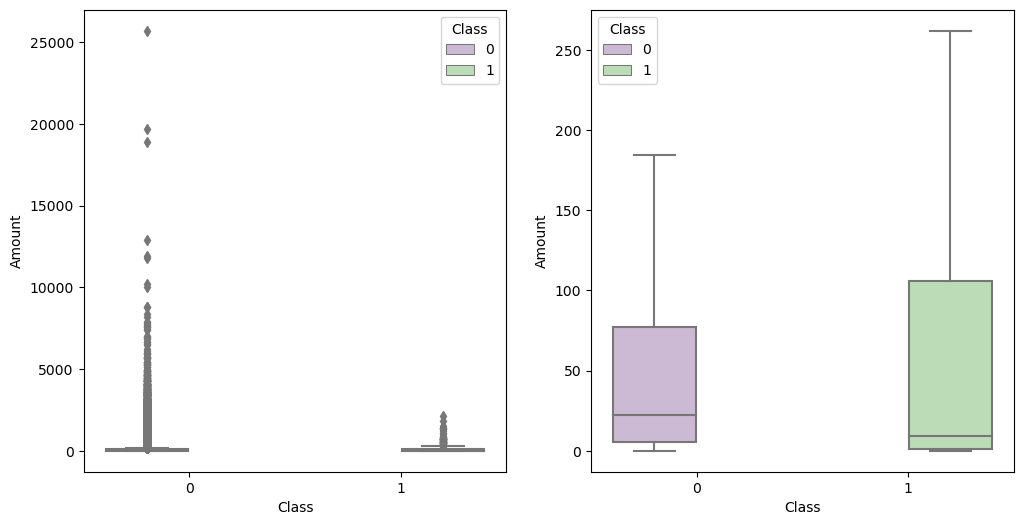

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

### 2.1.9 정상 거래(Class=0), 사기 거래(Class=1)의 금액 분포를 요약

In [17]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [18]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

| **특징**                  | **정상 거래 (Class=0)**                           | **사기 거래 (Class=1)**                          |
|---------------------------|--------------------------------------------------|-------------------------------------------------|
| **평균 값 (Mean)**         | 큼                                               | 작음                                            |
| **제1사분위수 (Q1)**       | 큼                                               | 작음                                            |
| **제3사분위수 (Q3)**       | 작음                                             | 큼                                              |
| **제4사분위수 (Q4)**       | 작음                                             | 큼                                              |
| **이상치 (Outliers)**      | 더 큼                                            | 더 작음                                         |

다음과 같이 정상 거래와 사기 거래를 비교할 수 있다.
<br>사기 거래에서 Q3, Q4가 크다는 것은 고액 거래가 사기일 가능성이 높다는 것을 의심할 수 있다.



사기 거래의 금액을 시간에 따라 플로팅 해본다. 
시간은 시작 시간으로부터 초 단위로 표시되며, 총 48시간, 즉 2일 동안의 데이터이다.

### 2.1.10 산점도(Scatter Plot)로 시각화

In [19]:
# 'Class'가 1인 (사기 거래) 데이터만 필터링
fraud = data_df.loc[data_df['Class'] == 1]

# Scatter 그래프를 위한 trace 정의
trace = go.Scatter(
    x = fraud['Time'],  # x축: 거래 발생 시간 (초 단위)
    y = fraud['Amount'],  # y축: 거래 금액
    name="Amount", 
    marker=dict(
        color='rgb(238,23,11)',  
        line=dict(
            color='red', 
            width=1  
        ),
        opacity=0.5, 
    ),
    text=fraud['Amount'], 
    mode="markers"  
)

data = [trace]

layout = dict(
    title='사기 거래 금액',  
    xaxis=dict(title='시간 [초]', showticklabels=True),  # x축 레이블: 시간
    yaxis=dict(title='금액'),  # y축 레이블: 거래 금액
    hovermode='closest'  
)

# 레이아웃과 데이터를 결합하여 그래프 출력
fig = dict(data=data, layout=layout)

# 그래프 출력
iplot(fig, filename='fraud-amount')

## 2.2 특징 상관관계

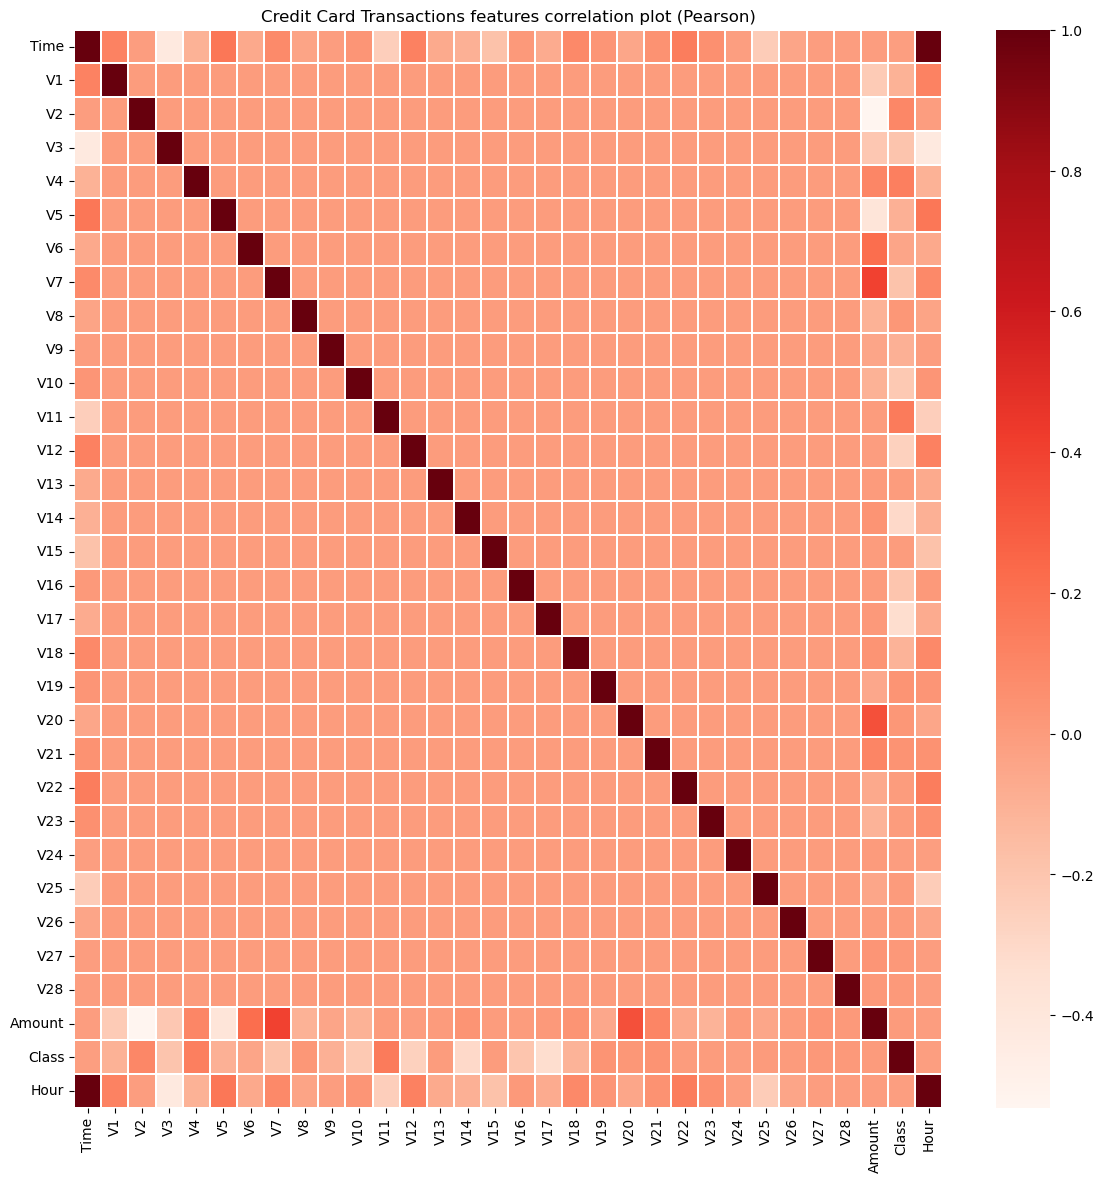

In [20]:
plt.figure(figsize = (14,14))

#신용 카드 거래는 상관 플롯을 특징으로 한다.
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()


#### 상관관계 분석 결과

<br>1. **특징 간 상관관계**
   - V1에서 V28까지의 특징들 간에는 눈에 띄는 상관관계가 없음.

<br>2. **특정 변수와의 상관관계**
   - **Time**:
     - V3: **역상관 관계** (Negative Correlation).
   - **Amount**:
     - V7, V20: **직상관 관계** (Positive Correlation).
     - V1, V5: **역상관 관계** (Negative Correlation).

<br>3. **추가 분석 필요**
   - 상관관계가 있는 변수와 역상관관계가 있는 변수를 같은 그래프에 시각화하여 관계를 더 명확히 파악해야 함.

<b>-> 직상관 관계가 있는 값들부터 시작(V20, V7)</b>

### 2.2.1 직상관 관계

<function matplotlib.pyplot.show(close=None, block=None)>

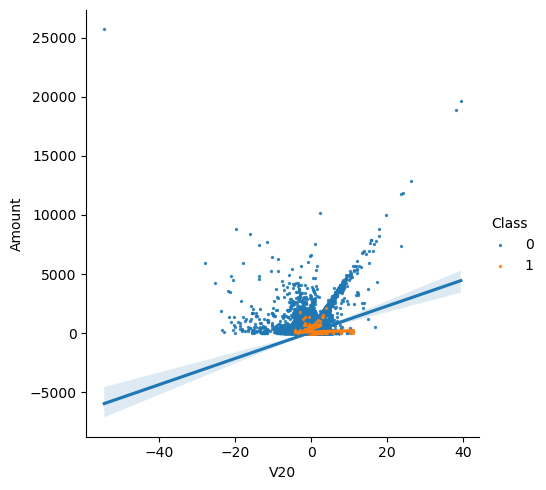

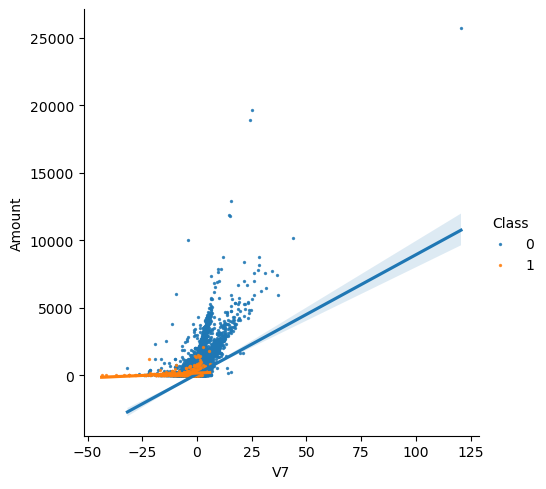

In [23]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show

### 상관 관계 분석 (V20, V7)

1. **Class = 0 (정상 거래)**
   - 회귀선의 기울기: **양의 기울기**
   - `V20` 및 `V7` 변수와 거래 금액(`Amount`) 간에 **양의 상관관계**가 뚜렷함.

2. **Class = 1 (사기 거래)**
   - 회귀선의 기울기: **더 작은 양의 기울기**
   - `V20` 및 `V7` 변수와 거래 금액 간에 관계가 약하지만, 여전히 **양의 상관관계**를 가짐.

3. **결론**
   - `V20`과 `V7` 변수는 거래 금액과 **양의 상관 관계**를 가진다.


### 2.2.2 역상관 관계

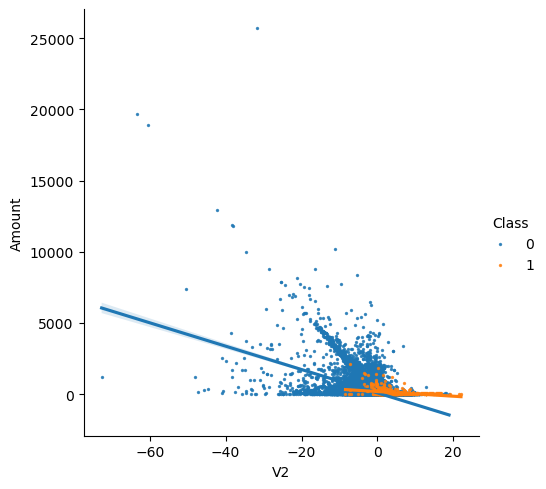

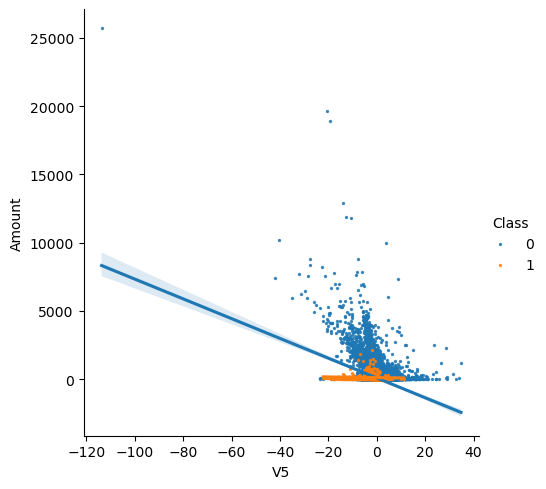

In [24]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

### 역상관 관계 분석 (V2, V5)

1. **Class = 0 (정상 거래)**
   - 회귀선의 기울기: **음의 기울기**
   - `V2` 및 `V5` 변수와 거래 금액(`Amount`) 간에 **역상관 관계**가 명확히 나타남.

2. **Class = 1 (사기 거래)**
   - 회귀선의 기울기: **매우 작은 음의 기울기**
   - `V2` 및 `V5` 변수와 거래 금액 간의 관계가 약하거나 거의 없음.

3. **결론**
   - `V2`와 `V5`는 거래 금액과 **역상관 관계**를 가짐.


## 2.3 특징 밀도 그래프

/var/folders/zd/dckz14216jqc68nsrxg1hzt40000gn/T/ipykernel_50793/3791969398.py:14: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/var/folders/zd/dckz14216jqc68nsrxg1hzt40000gn/T/ipykernel_50793/3791969398.py:15: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



<Figure size 640x480 with 0 Axes>

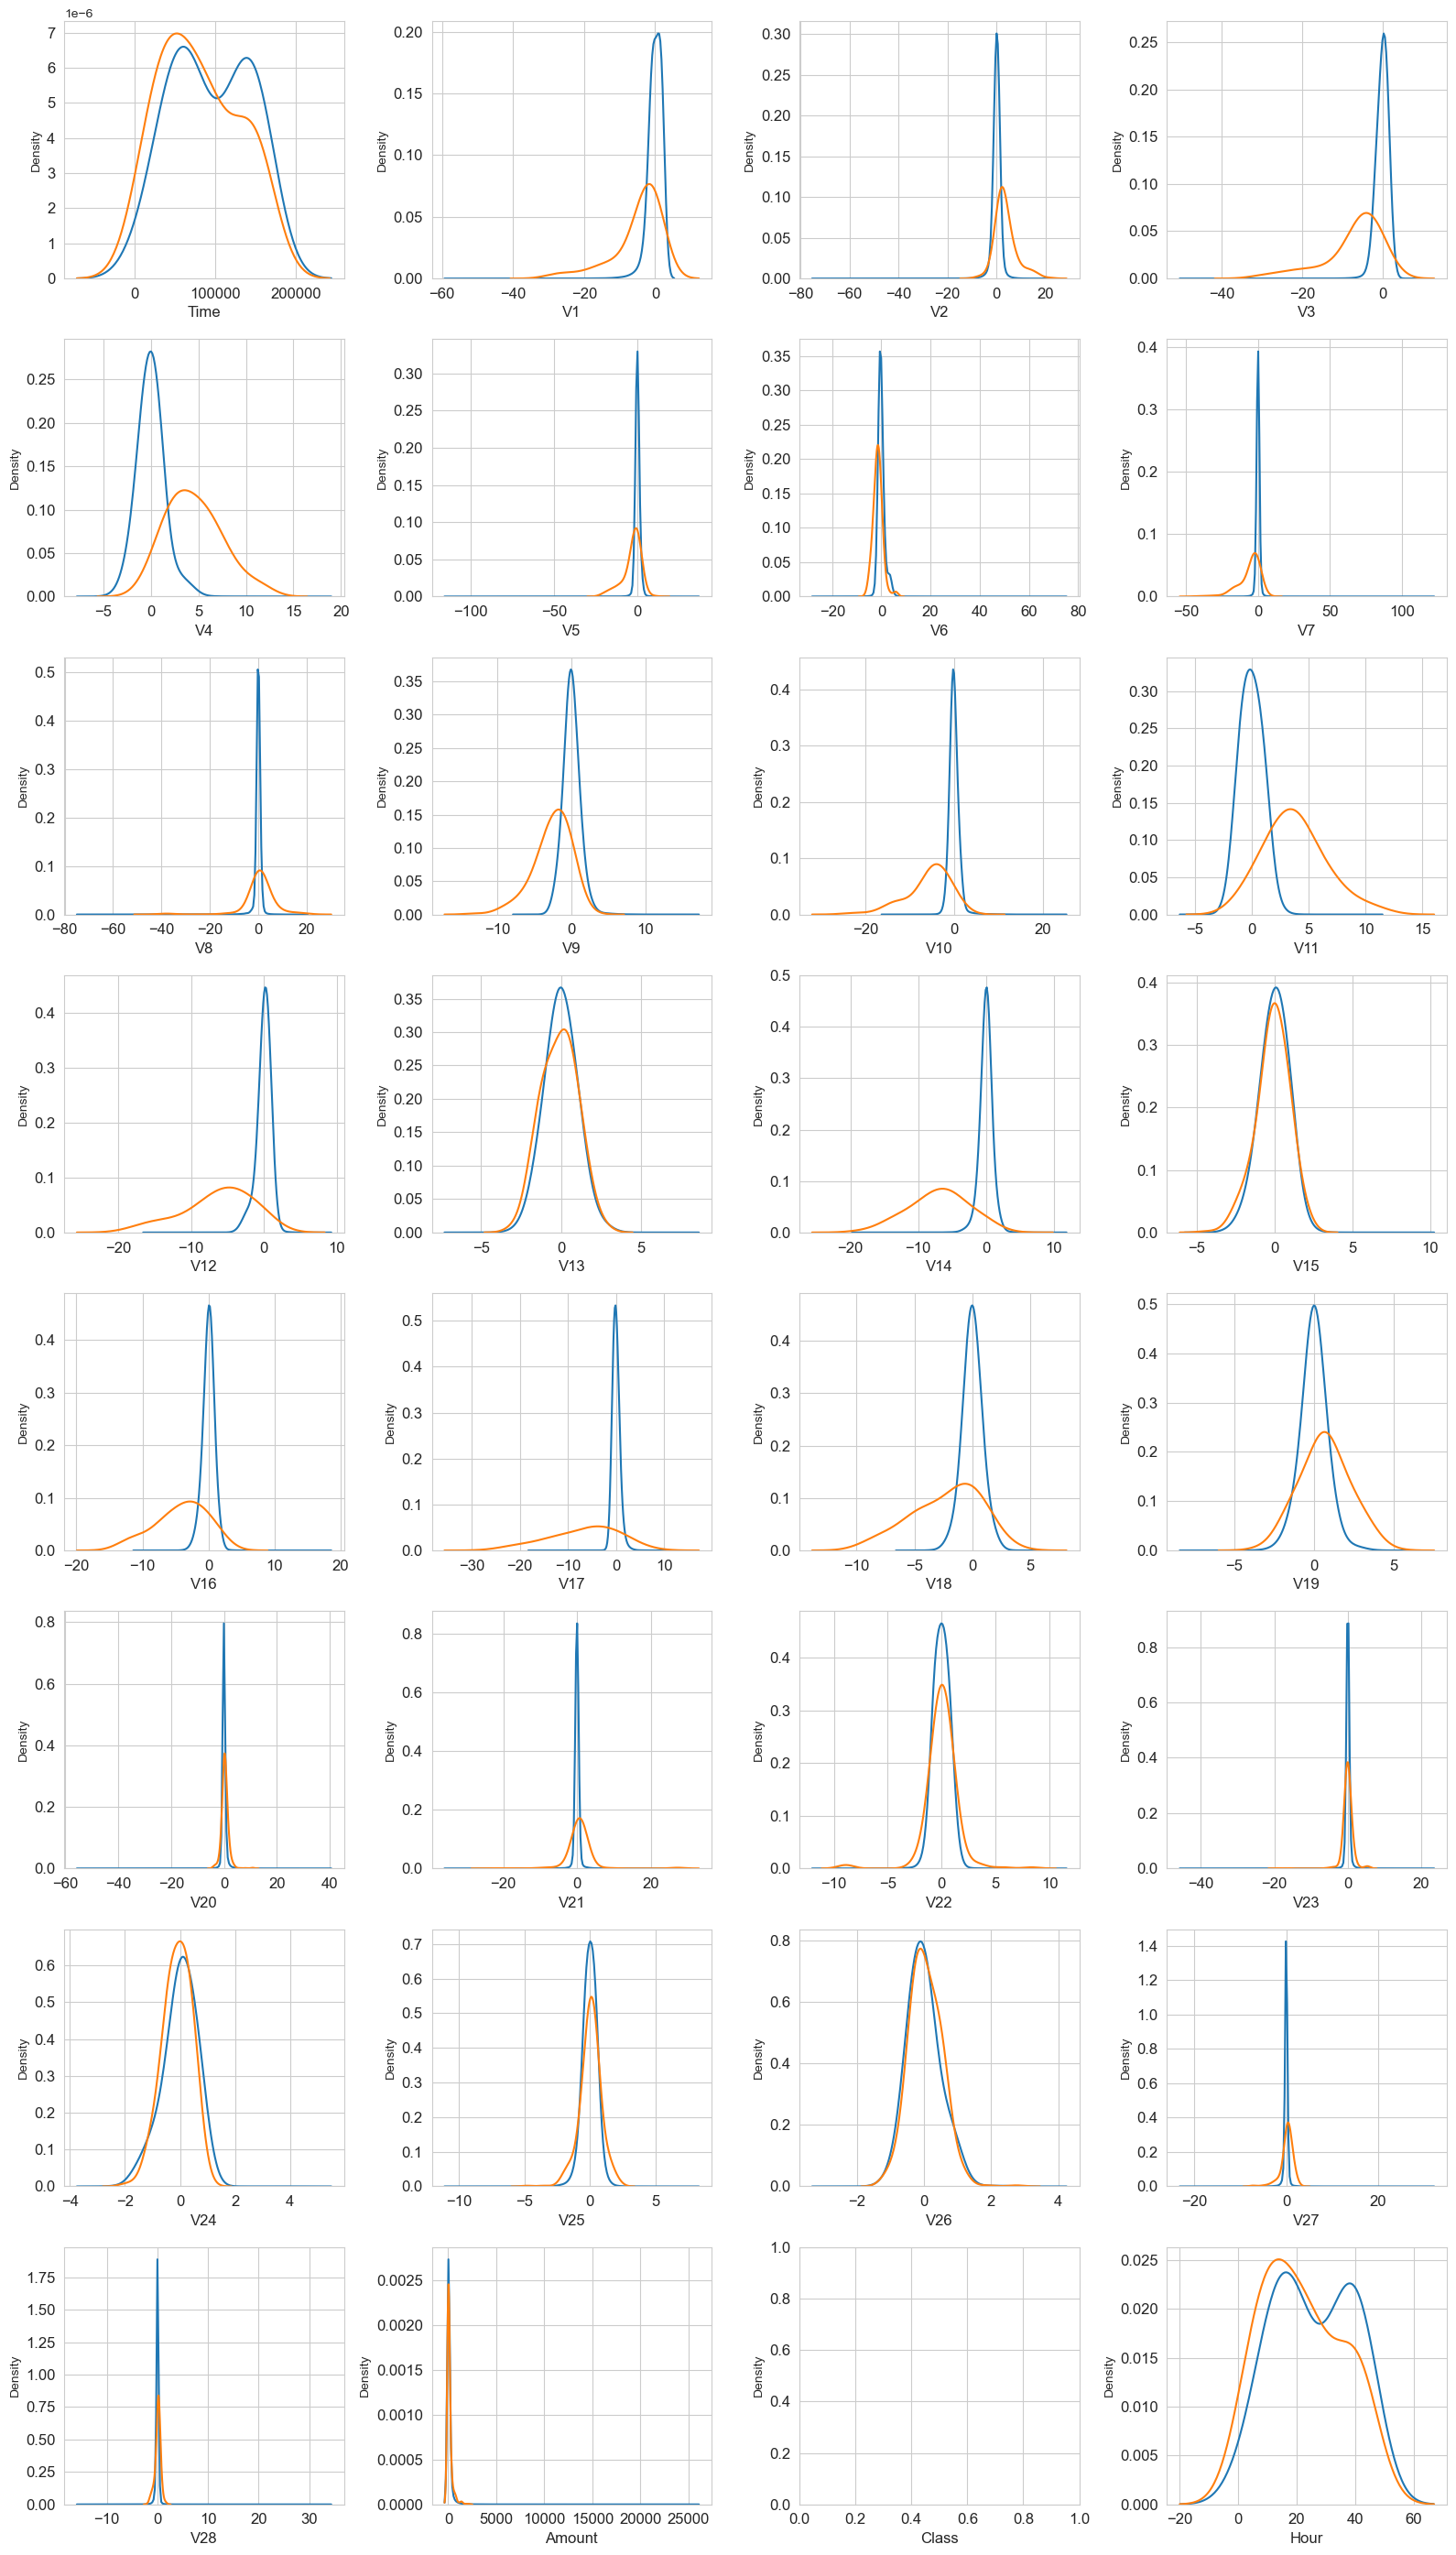

In [26]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8, 4, figsize=(16, 28))

for feature in var:
    i += 1
    plt.subplot(8, 4, i)
    sns.kdeplot(t0[feature], bw_method=0.5, label="Class = 0")
    sns.kdeplot(t1[feature], bw_method=0.5, label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()  # 플롯 간 여백 최적화
plt.show()

### 특징별 Class 값에 따른 분포 분석

#### 1. 특징별 Class 분포 차이

- **명확히 구분된 분포**:
  - `V4`, `V11`: Class 값이 0과 1에 대해 **명확히 구분된 분포**를 보임.

- **부분적으로 구분된 분포**:
  - `V12`, `V14`, `V18`: Class 값이 0과 1에 대해 **부분적으로 구분된 분포**를 보임.

- **명확한 차이를 보이는 분포**:
  - `V1`, `V2`, `V3`, `V10`: Class 값에 따라 분포가 다르게 나타나며 **명확한 차이**를 보임.

- **유사한 분포**:
  - `V25`, `V26`, `V28`: Class 값이 0과 1에 대해 **유사한 분포**를 보임.
    - 두 클래스 간에 큰 차이가 없어 사기 탐지에서 중요도가 낮을 가능성이 있음.

---

#### 2. 정상 거래와 사기 거래의 분포 차이

- **정상 거래 (`Class = 0`)**:
  - 대부분의 특징이 **0을 중심**으로 분포.
  - 일부 특징에서는 한쪽 끝에 긴 꼬리(**Skewness**)가 나타남.
    - **해석**: 정상 거래는 대체로 정상적인 범위 내에서 분포하며, 특정 극단 값이 발생할 수 있음.

- **사기 거래 (`Class = 1`)**:
  - **비대칭적인 분포**를 보임.
    - **해석**: 사기 거래는 분포가 왜곡되어 있으며, 일부 특징에서 비정상적인 값을 가지는 경향이 있음.

# 3. 모델학습

## 3.1 예측 모델

### 3.1.1 예측 변수와 타켓 변수 정의하기

In [27]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### 타겟 변수 설명 (`Class`)

- **타겟 변수:** `Class`  
  - 거래의 정상 여부를 나타내는 이진 분류 라벨

- **값의 의미:**
  - `0`: 정상 거래 
  - `1`: 사기 거래 

- **목적:**  
  - 모델이 독립 변수(`predictors`)를 기반으로 `Class`를 예측

In [28]:
RANDOM_STATE = 2018

train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

### 데이터 분할 (`train_test_split`)

- **목적:** 데이터를 학습, 검증, 테스트 세트로 나누어 모델 성능 평가에 활용.

- **설정:**
  - `TEST_SIZE = 0.20`: 전체 데이터의 20%를 테스트 세트로 할당.
  - `VALID_SIZE = 0.20`: 학습 세트의 20%를 검증 세트로 할당.
  - `RANDOM_STATE = 2018`: 무작위 분할 시 일관성을 유지하기 위한 랜덤 시드 값.
  - `shuffle=True`: 데이터를 무작위로 섞은 뒤 분할.

- **코드 설명:**
  1. **1차 분할**  
     ```python
     train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
     ```
     - 전체 데이터(`data_df`)를 학습 세트(`train_df`)와 테스트 세트(`test_df`)로 분할.

  2. **2차 분할**  
     ```python
     train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True)
     ```
     - 학습 세트(`train_df`)를 다시 학습 세트와 검증 세트(`valid_df`)로 분할.

## 3.2 랜덤 포레스트

In [29]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [30]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [31]:
preds = clf.predict(valid_df[predictors])

### 3.2.1 특징 중요도

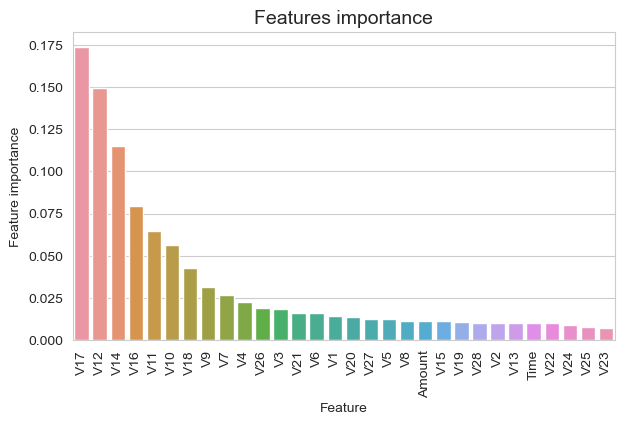

In [32]:
#특징 중요도

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### 가장 중요한 특징

- 가장 중요한 특징은 다음과 같다:
  - **V17**, **V12**, **V14**, **V10**, **V11**, **V16**

이들은 모델이 사기 거래 탐지에서 예측 성능에 가장 크게 기여한 변수들로, 데이터 분석 및 모델링에서 중점적으로 고려해야 할 변수들이다.

### 3.2.2 Confusion Matrix

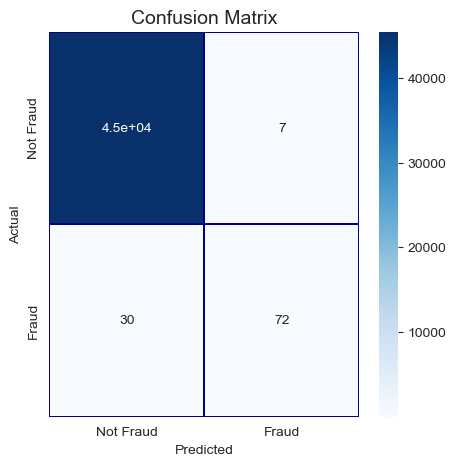

In [33]:
#Confusion Matrix

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Confusion Matrix 분석

#### 1. Confusion Matrix 구성
|                | Predicted: Not Fraud | Predicted: Fraud |
|----------------|-----------------------|------------------|
| **Actual: Not Fraud** | True Negative (TN): 45,000 | False Positive (FP): 7 |
| **Actual: Fraud**      | False Negative (FN): 30    | True Positive (TP): 72 |

---

#### 2. 주요 결과
- **정확도(Accuracy)**: 약 99.91%
- **False Positive (FP)**: 7건 (정상 거래를 사기로 잘못 분류)
- **False Negative (FN)**: 30건 (사기 거래를 정상으로 잘못 분류)

---

### 3.2.3 ROC-AUC 계산

In [34]:
#ROC-AUC 계산
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

## 3.3 XGBoost

In [35]:
# 훈련 및 검증 데이터셋 준비
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)  # 훈련 데이터셋
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)  # 검증 데이터셋
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)  # 테스트 데이터셋

# 모니터링할 데이터셋 정의 (훈련과 검증 데이터셋)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# xgboost 파라미터 설정
params = {}
params['objective'] = 'binary:logistic'  # 이진 분류 문제를 위한 설정
params['eta'] = 0.039  # 학습률
params['silent'] = True  # 훈련 중 출력 메시지 생략
params['max_depth'] = 2  # 트리의 최대 깊이
params['subsample'] = 0.8  # 훈련에 사용할 샘플 비율
params['colsample_bytree'] = 0.9  # 각 트리에서 사용할 특징의 비율
params['eval_metric'] = 'auc'  # 평가 지표로 AUC를 사용
params['random_state'] = RANDOM_STATE  # 랜덤 시드 설정

In [36]:
MAX_ROUNDS = 1000
EARLY_STOP = 50 
OPT_ROUNDS = 1000 
VERBOSE_EVAL = 50 

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94070	valid-auc:0.88630


/Users/one/anaconda3/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning:

Pass `evals` as keyword args.

/Users/one/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[14:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.




[50]	train-auc:0.94045	valid-auc:0.89040
[100]	train-auc:0.97428	valid-auc:0.96302
[150]	train-auc:0.98695	valid-auc:0.98056
[200]	train-auc:0.99276	valid-auc:0.98504
[250]	train-auc:0.99514	valid-auc:0.98432
[267]	train-auc:0.99569	valid-auc:0.98373


### 3.3.1 특징 중요도

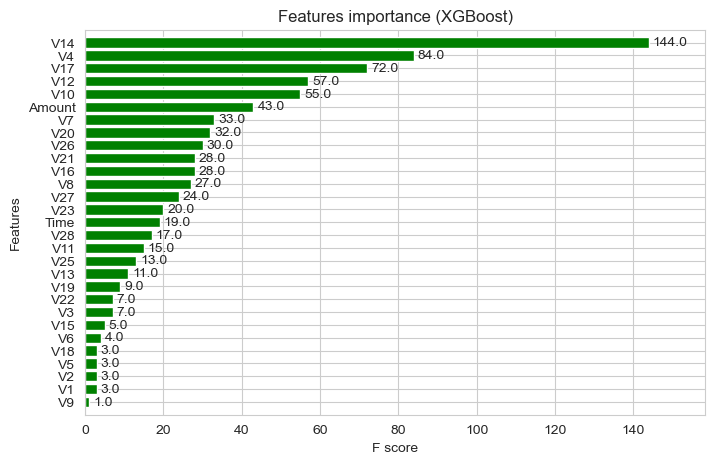

In [37]:
#특징 중요도

fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### 가장 중요한 특징

- 가장 중요한 특징은 다음과 같다:
  - **V14**, **V4**, **V17**, **V12**, **V10**

이들은 XGBoost 모델이 사기 거래 탐지에서 예측 성능에 가장 크게 기여한 변수들로, 데이터 분석 및 모델링에서 중점적으로 고려해야 할 변수들이다.

In [38]:
#목표값 예측 

preds = model.predict(dtest)

In [39]:
#Roc-Auc 계산

roc_auc_score(test_df[target].values, preds)

0.9806594034680455

# 4. 알고리즘 비교

## 4.1. 성능 비교

### 랜덤 포레스트 (Random Forest)
- **Roc-Auc**: 0.8528 (85.28%)
- 랜덤 포레스트는 여러 결정 트리를 앙상블하여 분류 작업을 수행하며, 직관적이고 비교적 빠르게 학습 가능.
- 하지만, 사기 탐지처럼 **불균형 데이터**에서 높은 정밀도(Precision)와 재현율(Recall)을 요구하는 작업에서는 한계가 있을 수 있음.

### XGBoost
- **Roc-Auc**: 0.9807 (98.07%)
- XGBoost는 Gradient Boosting 알고리즘을 기반으로 하며, 특화된 하이퍼파라미터 튜닝과 정규화 기법으로 높은 예측 성능을 달성.
- 특히 **불균형 데이터** 처리와 AUC 최적화에서 강점을 보임.

---

## 4.2 결론

### XGBoost의 우수한 성능
- **Roc-Auc 98.07%**로 랜덤 포레스트보다 훨씬 높은 성능을 보임.
- 이는 XGBoost가 **사기 거래 탐지와 같은 복잡하고 불균형한 데이터**에 대해 더 적합한 모델임을 보여줌.

### 알고리즘 선택
- 사기 탐지 문제에서는 **정확도, 정밀도, 재현율**이 모두 중요함.
- **XGBoost는 이러한 요구 사항을 더 잘 충족**하므로, 사기 탐지 작업에는 XGBoost를 사용하는 것이 더 적합함.

---


챗지피티 활용 부분

https://chatgpt.com/share/6756f41d-786c-8001-8eb8-ae3f1076e6eb

### ChatGPT 도움받은 부분

1. **데이터 이해 및 전처리**
   - 데이터 불균형 문제 파악 및 해결 방법 제안을 받음
     - 예: 언더샘플링, 오버샘플링, 클래스 가중치 조정
   - 컬럼별 통계 요약 및 시각화를 통한 분석 인사이트 제공

2. **모델 선택 및 하이퍼파라미터 설정**
   - **랜덤 포레스트**와 **XGBoost**의 장단점 비교
   - XGBoost 모델의 하이퍼파라미터 최적화
     - `max_depth`, `subsample`, `colsample_bytree` 등의 설정
     - 학습률 (`eta`) 최적화

3. **성능 평가 및 알고리즘 비교**
   - **Confusion Matrix** 생성 및 결과 해석
   - **ROC-AUC 점수** 계산 및 비교
   - 알고리즘 간 성능 차이를 설명하며 XGBoost의 적합성 도출

4. **신용카드 사기 예측 구현**
   - 사용자 입력값을 기반으로 사기 여부를 예측하는 함수 작성
   - 데이터 스케일링 및 예측값 반환 구현
   
5. **문서화**
   - 마크다운 문서 형식으로 프로젝트를 깔끔하게 정리
   - 주요 단계와 설명을 간결하게 요약

---